### This notebook will load the individual connectivty weights and analyze the `coef_` and `coef_1` and `coef_2`

In [1]:
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.evaluation as ev
import Functional_Fusion.dataset as fdata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def var_decomp(train_types):
    subset_tuple_list = []
    for dataset_name, (_, la) in train_types.items():
        subset_tuple_list.append((dataset_name, la))
    # Load the product matrix and metadata vectors 
    data = np.load("/home/UWO/ashahb7/Github/bayes_temp/bestSTD_product_matrix.npz", allow_pickle=True)
    subset_indices = np.where([(dataset, alpha) in subset_tuple_list for dataset, alpha in zip(data['dataset_vec'], data['logalpha_vec'])])[0]
    product_matrix = data['product_matrix'][subset_indices, :][:, subset_indices]
    dataset_vec = data['dataset_vec'][subset_indices]
    sub_vec = data['sub_vec'][subset_indices]
    part_vec = data['part_vec'][subset_indices]
    var_decom_df = rm.decompose_variance_from_SS_2(product_matrix, dataset_vec, sub_vec, part_vec)

    return var_decom_df

In [12]:
def calc_var_df(train_types):
    print("Starting variance decomposition...")
    var_dic = {'train_dataset': [],
               'logalpha': [],
               'subj_id': [],
               'coef_norm': [],
               'correlation': []}
    
    var_decom_df = var_decomp(train_types)

    for dataset_name, (ses, la) in train_types.items():
        print(f"\nProcessing dataset: {dataset_name}, session: {ses}, logalpha: {la}")
        config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses=ses, model='ind', cerebellum='MNISymC3', add_rest=True)
        dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
        config["subj_list"] = dataset.get_participants().participant_id
        S = len(config['subj_list'])

        dirname = f"{dataset_name}_{ses}_Icosahedron1002_L2reghalf"
        mname = f"{dataset_name}_{ses}_Icosahedron1002_L2reghalf_A{la}"

        fm, _ = rm.get_fitted_models([dirname], [mname], config)
        fm = fm[0]

        for s in range(S):
            coef_norm = np.linalg.norm(np.nan_to_num(fm[s].coef_))
            var_dic['coef_norm'].append(coef_norm)
            R = np.corrcoef(fm[s].coef_1.flatten(), fm[s].coef_2.flatten())[0, 1]
            var_dic['correlation'].append(R)
        var_dic['subj_id'].extend(config["subj_list"])
        var_dic['logalpha'].extend([la] * S)
        var_dic['train_dataset'].extend([dataset_name] * (len(var_dic['subj_id']) - len(var_dic['train_dataset'])))

    print("\nCreating DataFrame...")
    var_df = pd.DataFrame(var_dic)
    var_df = var_df.merge(var_decom_df, on=['train_dataset', 'subj_id'], how='left')
    var_df['coef_var'] = var_df['v_d'] + var_df['v_s'] + var_df['v_m'] / 2
    var_df['effective_weight'] = 1 / (var_df['sc'] * var_df['coef_var'])
    var_df['contribution'] = var_df['effective_weight'] * var_df['coef_norm']
    return var_df

In [3]:
# dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto"]
# logalpha_list = [8, 8, 8, 8, 8, 8]
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
logalpha_list = [6, 6, 6, 2, 2, 8, 6]
train_types = {}
for dataset_name, la in zip(dataset_list, logalpha_list):
    if dataset_name == 'Language':
        train_types[dataset_name] = ('ses-localizer_cond', la)
    else:
        train_types[dataset_name] = ('all', la)

In [14]:
full_var_df = calc_var_df(train_types)
full_var_df.to_csv('/home/UWO/ashahb7/Github/bayes_temp/full_decom_var_df.tsv', sep='\t', index=False)

Starting variance decomposition...
Bad pairs (cross-dataset): 9.85%
Bad pairs (cross-subject): 1.51%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%

Processing dataset: MDTB, session: all, logalpha: 6

Processing dataset: Language, session: ses-localizer_cond, logalpha: 6

Processing dataset: WMFS, session: all, logalpha: 6

Processing dataset: Demand, session: all, logalpha: 2

Processing dataset: Somatotopic, session: all, logalpha: 2

Processing dataset: Nishimoto, session: all, logalpha: 8

Processing dataset: IBC, session: all, logalpha: 6

Creating DataFrame...


In [4]:
best_full_var_df = pd.read_csv('/home/UWO/ashahb7/Github/bayes_temp/full_decom_var_df.tsv', sep='\t')

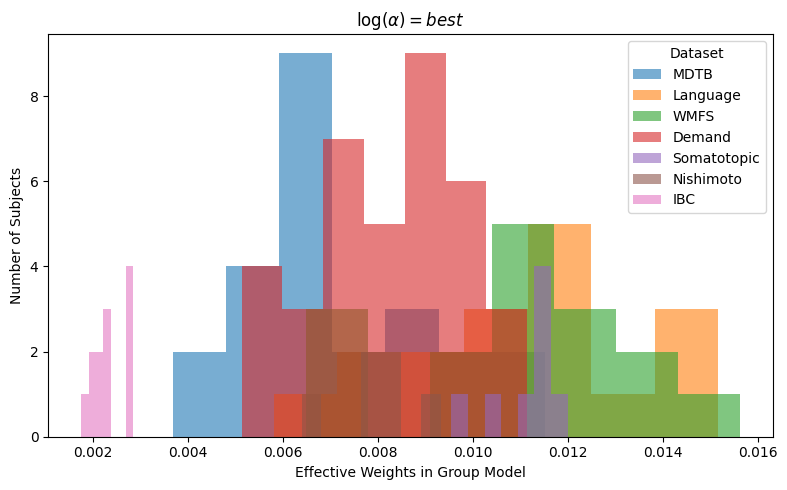

In [5]:
plt.figure(figsize=(8,5))
all_weights = np.sum(best_full_var_df.effective_weight)
for dataset_name in dataset_list:
    plt.hist(best_full_var_df[best_full_var_df.train_dataset == dataset_name].effective_weight / all_weights, bins=7, alpha=0.6, label=dataset_name)
plt.xlabel('Effective Weights in Group Model')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.title(r'$\log(\alpha)=best$')
plt.tight_layout()
plt.show()

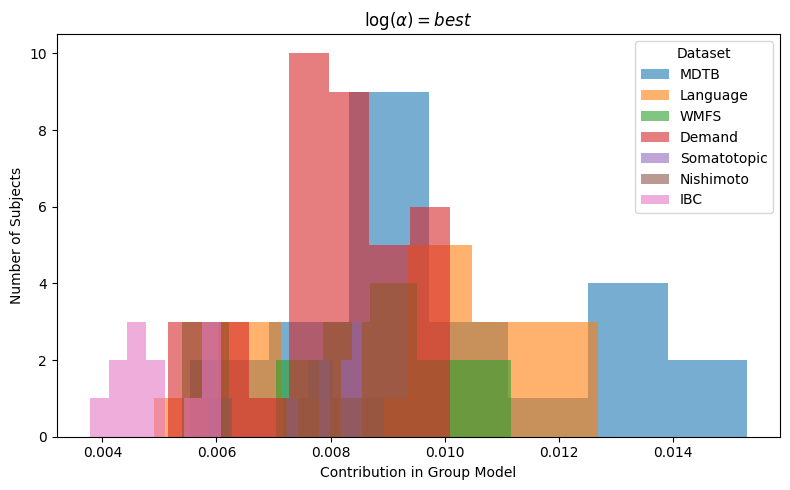

In [6]:
plt.figure(figsize=(8,5))
all_contribution = np.sum(best_full_var_df.contribution)
for dataset_name in dataset_list:
    plt.hist(best_full_var_df[best_full_var_df.train_dataset == dataset_name].contribution / all_contribution, bins=7, alpha=0.6, label=dataset_name)
plt.xlabel('Contribution in Group Model')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.title(r'$\log(\alpha)=best$')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of Subjects from each Dataset')

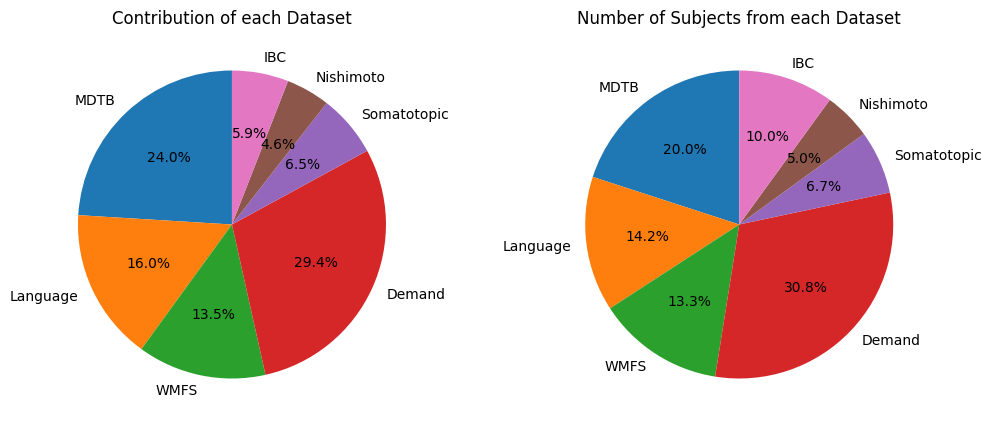

In [7]:
plt.subplots(1,2, figsize=(12,5))
plt.subplot(1,2,1)
plt.pie(best_full_var_df.groupby('train_dataset')['contribution'].sum().reindex(dataset_list), labels=dataset_list, autopct='%1.1f%%', startangle=90)
plt.title('Contribution of each Dataset')
plt.subplot(1,2,2)
plt.pie(best_full_var_df.groupby('train_dataset').size().reindex(dataset_list), labels=dataset_list, autopct='%1.1f%%', startangle=90)
plt.title('Number of Subjects from each Dataset')

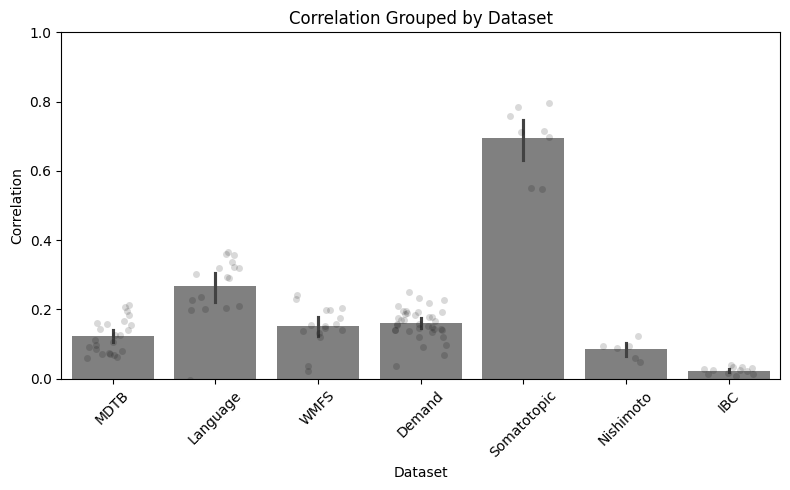

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(data=best_full_var_df, x='train_dataset', y='correlation', order=dataset_list, color=[0.5,0.5,0.5])
sns.stripplot(data=best_full_var_df, x='train_dataset', y='correlation', order=dataset_list, color=[0,0,0], alpha=0.15, jitter=0.25)
plt.xlabel('Dataset')
plt.ylabel('Correlation')
plt.title('Correlation Grouped by Dataset')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()